In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string as s

from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# the wrapper the instructor team provided 
from DocumentSimilarity import DocumentSimilarity


#set a random seed for reproducibility
np.random.seed(1)

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

This section covers user defined functions for the project

In [2]:
def get_keywords_tfidf(document_list):
    '''
    Input: cleaned 10K Report of the different firms
    Output: The corresponding top 10 keywords for each firm based on tf-idf values
    '''
    
    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)

    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):
        
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    
    return top_keywords

In [3]:
translator = str.maketrans('', '', s.punctuation)
stop_word = stopwords.words('english')

def clean_text(text: str)->str:
    """ clean the input text following these steps
        * Convert all words to lowercase.
        * Remove punctuations.
        * Remove stop words based on the list of English stop words in NLTK.

        input: Dataframe and the column of interest
        return: Dataframe
    """    
    # convert all words to lower case
    clean_text = text.lower()

    # remove punctuation
    clean_text = clean_text.translate(translator)

    # remove stopwords
    clean_words = [word for word in clean_text.split() if word not in stop_word]
    
    return ' '.join(clean_words)

In [4]:
def get_keywords_wc(text: str)->str:
    """get the top 10 keywords based on word count"""
    c = Counter(text.split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join(words)

The _`get_sic()`_ fucntion gets the first two digits of any code passed in.<br>
These first two digits corresponds to the `sic code` for the different sectors.<br>
_`get_sic()`_ accepts and integer value, converts the integer to a string, slice the string to get the first two index and returns an int type of the first two digits

In [5]:
def get_sic(sic: int)->int:
    '''
    get the sic for the different industries

    @params
    input: int
    return: int
    '''
    code = int(str(sic)[:2])
    return code


Part 1. Quantitative Analysis of the Industry Sector<br>

A. Industry Sector Selection and Data Filtering<br>

Load the datasets and filter the data include only the firms belonging to the Business Services sector - retain all firms whose SIC codes start with 73. Having filtered the dataset for Business Service sector, we answered the following questions::<br>

1. How many unique firm-year ("fyear") observations are there in the filtered dataset?<br>
2. How many unique firms are there in the filtered dataset?<br>
3. How many firms in the filtered dataset have records over all 27 years (1994-2020)<br>


In [6]:
# load the major_groups dataset as pandas dataframe
# display first five rows of the dataset for inspection
df_major_group = pd.read_csv(r'major_groups.csv')
df_major_group.head()

,major_group,description
0,1,Agricultural Production Crops
1,2,Agriculture production livestock and animal sp...
2,7,Agricultural Services
3,8,Forestry
4,9,Fishing hunting and trapping


In [7]:
# load the public firms dataset as pandas dataframe
# display five rows selected at random for inspection
df_public_firms = pd.read_csv(r'public_firms.csv')
df_public_firms.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
0,1004,1994,USA,AAR CORP,1988/01/01,5080,13.375,22.487,10.463,425.814,451.395,0.024572
1,1004,1995,USA,AAR CORP,1988/01/01,5080,22.000,33.606,16.012,437.846,504.990,0.036570
2,1004,1996,USA,AAR CORP,1988/01/01,5080,30.250,51.705,23.025,529.584,589.328,0.043478
3,1004,1997,USA,AAR CORP,1988/01/01,5080,38.750,17.222,35.657,670.559,782.123,0.053175
4,1004,1998,USA,AAR CORP,1988/01/01,5080,23.875,8.250,41.671,726.630,918.036,0.057348


The code block below creates a new column on `public_firms` dataset using the _`get_sic()`_ function<br>
The new column is the two digit ``sic code`` for the different sectors

In [8]:
# create a new column for the two digit sic code
# display the first five rows of the dataset
df_public_firms['sic_code'] = df_public_firms.sic.apply(get_sic)
df_public_firms.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,sic_code
0,1004,1994,USA,AAR CORP,1988/01/01,5080,13.375,22.487,10.463,425.814,451.395,0.024572,50
1,1004,1995,USA,AAR CORP,1988/01/01,5080,22.000,33.606,16.012,437.846,504.990,0.036570,50
2,1004,1996,USA,AAR CORP,1988/01/01,5080,30.250,51.705,23.025,529.584,589.328,0.043478,50
3,1004,1997,USA,AAR CORP,1988/01/01,5080,38.750,17.222,35.657,670.559,782.123,0.053175,50
4,1004,1998,USA,AAR CORP,1988/01/01,5080,23.875,8.250,41.671,726.630,918.036,0.057348,50


The code block below filters the dataset for only companies whose `sic code` starts with `73` (Business services)<br>
The dataset is filtered using the _`sic_code`_ column and retains the records that meets the condition _`sic_code == 73`_
This approach is called `subsetting`

In [9]:
# create a new dataframe that contains only the selected sector - Business Services
# display the first five rows of the dataset
df = df_public_firms[df_public_firms.sic_code == 73]
df.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,sic_code
53,1019,1995,USA,AFA PROTECTIVE SYSTEMS INC,NaN,7380,115.0,4.565,1.339,28.487,27.492,0.047004,73
54,1019,1996,USA,AFA PROTECTIVE SYSTEMS INC,NaN,7380,117.0,5.293,1.060,28.968,27.160,0.036592,73
55,1019,1997,USA,AFA PROTECTIVE SYSTEMS INC,NaN,7380,215.0,1.654,1.139,26.710,29.740,0.042643,73
56,1019,1998,USA,AFA PROTECTIVE SYSTEMS INC,NaN,7380,207.0,1.507,1.647,29.283,34.175,0.056244,73
57,1019,1999,USA,AFA PROTECTIVE SYSTEMS INC,NaN,7380,206.0,1.187,1.024,29.341,37.272,0.034900,73


Description for the code block below:<br>

1. To calculate the total unique firm-year in the dataset, we selected the `fyear` column using dot notation and used<br>
the `nunique()` function to count the number of unique entries in the resulting pandas `series`.<br>

2. To calculate the total unique firms in the dataset, we selected the `conm` column using dot notation and used the<br> `nunique()` function to count the number of unique entries in the resulting pandas `series`.<br>

3. To calculate the total firms with entries for the `27 years` in the dataset, we grouped the dataset on the `conm` column `df.groupby('conm')`.<br> 
For each group formed in the previous step, we count the number of unique values in the `fyear` column `fyear.nunique()`.<br>
The `>= _unique_firm_year` checks if the number of unique fiscal years is greater than or equal to `_unique_firm_year: 27`. The operation results in a boolean Series (True or False values). The final `sum()` function counts the number of `True` values in the boolean Series. This essentially counts the number of companies that have a number of unique fiscal years greater than or equal to `_unique_firm_year: 27`.


In [10]:
# 1. Unique firm-year in the filtered dataset
_unique_firm_year = df.fyear.nunique()
print(f'The total unique firm year is: {_unique_firm_year}\n')


# 2. Unique firms in the filtered dataset
_unique_firms = df.conm.nunique()
print(f'Total unique firms in the dataset is: {_unique_firms}\n')

# 3. Total number of firms with entries across for the entire 27 years
num_records = (df.groupby('conm').fyear.nunique() >= _unique_firm_year).sum()
print('A total of {} firms have records over all {} years (1994 - 2020)'.format(num_records, 27))

The total unique firm year is: 27

Total unique firms in the dataset is: 3022

A total of 12 firms have records over all 27 years (1994 - 2020)


B.	Preliminary Analysis:<br>

In this section, we perform preliminary analysis to know:

1.	the top 10 firms with the highest stock price in the year 2020<br>
2.	the top 10 firms with the highest sales in the entire history of the dataset<br>
3.	the geographical distribution of all the firms<br>
4.	the average stock price trend (line chart)<br>
5.	the firm affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008<br>
6.  visualize the Return on Assets (ROA) for the firms located in the “USA” across the years. The ROA is calculated as ni/asset.



1. The code block below subsets the dataset and retrieve records for the year `2020` retaining three columns of interest `conm`, `sic`, and `prcc_c`<br>
The `.sort_values` method sorts the resulting dataframe on the stock price column `prcc_c` in descending order and we retrieved the <br>highest stock price for the year `2020` using the slicing approach.

    Finding: `Oracle Corp` is not in the top 10 firms with the highest stock price the year `2020` 

In [11]:
# 1. Top 10 firms with the highest stock price in 2020
firms = df[df.fyear == 2020][['conm', 'sic', 'prcc_c']]
firms.sort_values('prcc_c', ascending = False)[:10]

,conm,sic,prcc_c
157765,BOOKING HOLDINGS INC,7370,2227.27
181266,ALPHABET INC,7370,1752.64
194447,MERCADOLIBRE INC,7370,1675.22
80148,SHOPIFY INC,7370,1131.95
153194,COSTAR GROUP INC,7370,924.28
93748,TRADE DESK INC,7370,801.00
189431,SERVICENOW INC,7372,550.43
53536,FAIR ISAAC CORP,7373,511.04
47301,ADOBE INC,7370,500.12
72443,PAYCOM SOFTWARE INC,7370,452.25


2. The code block below:<br>
Groups the dataframe by firm `conm`, sums the total sales for each group (firm) and returns the largest sales value<br>
The `reset_index()` method tells python to treat `conm` as a column and not as the index of the dataframe

    Finding: `International Business Machine (IBM)` is leading in total sales (1994 - 2020) in the Business Services sector. `Oracle Corp` is the sixth largest firm in total sales for the period covered.


In [12]:
# 2. Top 10 firms with the highest sales in the history of the dataset
df.groupby('conm')[['sale']].sum().nlargest(10, 'sale').reset_index()

,conm,sale
0,INTL BUSINESS MACHINES CORP,2292210.000
1,MICROSOFT CORP,1478403.000
2,FUJITSU LTD,1150112.022
3,ALPHABET INC,1084424.241
4,NEC CORP,704691.827
5,ORACLE CORP,615899.432
6,MANPOWERGROUP,411631.456
7,SAP SE,391300.733
8,DXC TECHNOLOGY CO,347415.069
9,ALIBABA GROUP HLDG,345640.394


3. The code block below:<br>
Groups the dataframe by location `location`, calculates the total unique firm for each location and returns the top 10 locations<br>
The `reset_index()` method tells python to treat `location` as a column and not as the index of the dataframe

   Finding: The total firms in the `US` is more than `4x` the other locations in the top 10

In [13]:
# 3. Geographical distribution of firms
df.groupby('location')[['conm']].nunique().nlargest(10, 'conm').reset_index()

,location,conm
0,USA,2531
1,CHN,143
2,CAN,89
3,ISR,66
4,GBR,47
5,HKG,26
6,IRL,17
7,JPN,10
8,DEU,9
9,FRA,8


4. Creating the line plot for the `average stock price` for the 27 year period<br>
We grouped the dataset by `year` and calculated the mean price for each `year group` using the `groupby` and `mean` function respectively<br>
Using the `plot` function, we created a `line chart` of year on the `x-axis` and average stock price on the `y-axis`

   Finding: The plot shows a sharp increase in average stock price from `2018 - 2020` and a sharp decrease between `1999 - 2000` and `2007 - 2008`<br>
The significant decrease in `2007 - 2008` can be attributed to the financial crisis in `2008`. Overall, the average stock price has increased from <br> about `$11` in `1994` to over `$70` in `2020`


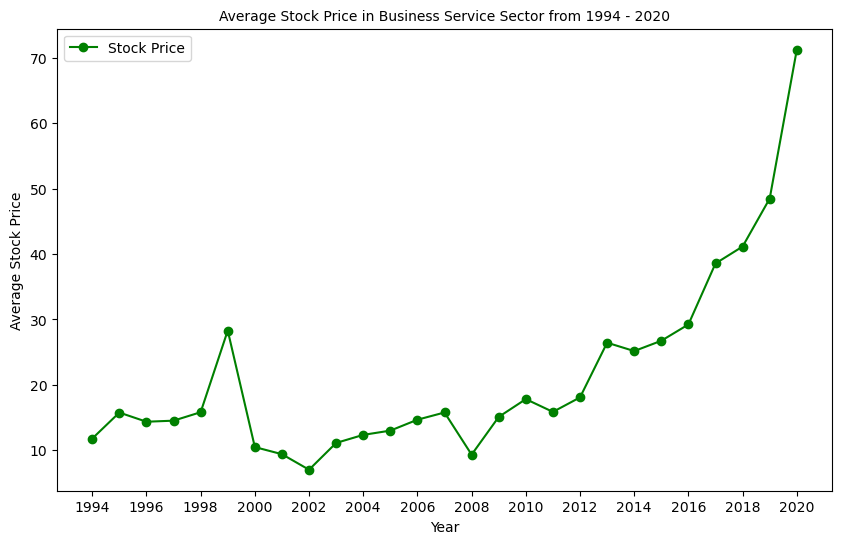

In [14]:
# 4. Line chart of the average stock price in Social Services
plt.figure(figsize = (10, 6))
average_price = df.groupby('fyear')['prcc_c'].mean().reset_index()
plt.plot(average_price.fyear, average_price.prcc_c, label = 'Stock Price', color = 'g', marker = 'o')
plt.xticks(average_price['fyear'][::2])
plt.title('Average Stock Price in Business Service Sector from 1994 - 2020', size = 10)
plt.xlabel('Year')
plt.ylabel('Average Stock Price')
plt.legend()
plt.show()

5. Finding the most affected firm by the 2008 Financial crisis:<br>
The code block below subsets the filtered dataset and retrieves records for `2007` and `2008`<br>
Using the resulting subset of the dataframe, we used the `pivot` function to change the orientation of the dataframe (tranform rows to columns)<br>
and dropped `NaN`

In [15]:
# 5. The most affected firm by the 2008 Financial Crisis
firms_df = df[df['fyear'].isin([2007,2008])]
_df = firms_df.pivot(index = 'conm', columns = 'fyear', values = 'prcc_c').dropna()
_df.head()

fyear,2007,2008
conm,,
51JOB INC,18.020,6.160
A D A M INC,8.370,4.000
ABLEAUCTIONS.COM INC,0.131,0.023
ABM INDUSTRIES INC,20.390,19.050
ACCELRYS INC,7.530,4.360


Using the resulting dataframe from the previous operation, create a new column that calculates the percentage drop in stock price between `2007` and `2008`<br>
Retriieve the index and name of the most affected firm

In [16]:
_df['percentage_drop'] = ((_df[2007] - _df[2008]) / _df[2007]) * 100
most_affected = _df.percentage_drop.idxmax()
p_drop = _df.percentage_drop.max()
print(f'The most affected firm is: {most_affected} with {(p_drop):.2f}% drop in price')

The most affected firm is: ISSUER DIRECT CORP with 99.43% drop in price


6. The code block below subsets the entire dataframe and retrieves only the firms located in the US and the columns of interest<br>
`fyear`, `ni`, `asset`. We create a new column on the new subset of the dataset doing a row-wise calculation of the `return on assets (roa)`<br>
using the `ni` and `asset` columns. _`roa = ni / asset`_

In [17]:
# 6. Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.
US_firms = df[df.location == 'USA'][['fyear', 'ni', 'asset']]
US_firms['roa'] = US_firms['ni'] / US_firms['asset']
US_firms.head()

,fyear,ni,asset,roa
53,1995,1.339,28.487,0.047004
54,1996,1.060,28.968,0.036592
55,1997,1.139,26.710,0.042643
56,1998,1.647,29.283,0.056244
57,1999,1.024,29.341,0.034900


The code block below groups the dataset by firm `conm` and computes the average return on asset `roa` for each firm in the US<br>
Using the `plot` we created a line chart showing the average `roa` for US firms.

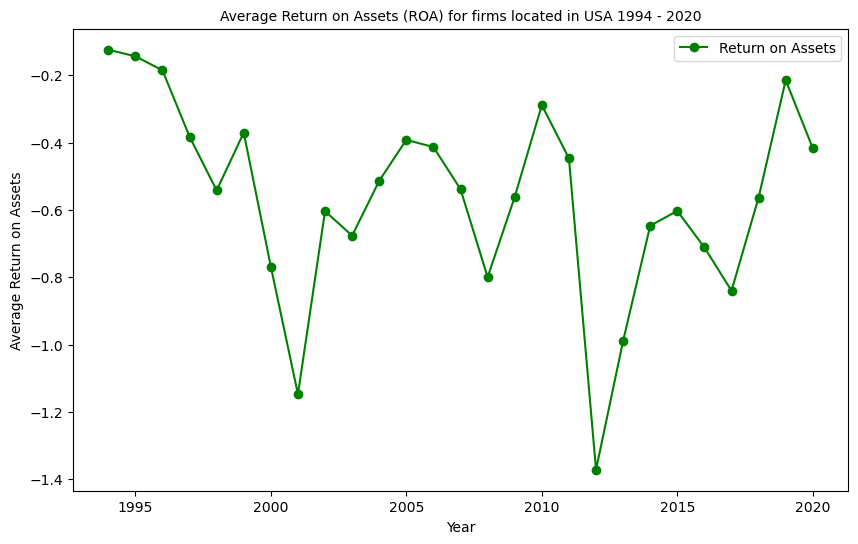

In [18]:
# plot the return on asset (roa)
plt.figure(figsize = (10, 6))
avg_roa = US_firms.groupby('fyear')['roa'].mean()
plt.plot(avg_roa, label = 'Return on Assets', color = 'g', marker = 'o')
plt.title('Average Return on Assets (ROA) for firms located in USA 1994 - 2020', size = 10)
plt.xlabel('Year')
plt.ylabel('Average Return on Assets')
plt.legend()
plt.show()

Part 2. Text Analysis on the Industry Sector:<br>

In this section cleaned the 10-K report of sample 5,988 firms and created a new column containing the cleaned text for each "item1" content

1.	Convert all words to lowercase.<br>
2.	Remove punctuations.<br>
3.	Remove stop words based on the list of English stop words in NLTK.<br>


In [19]:
# load the 10-K report dataset into pandas dataframe
# drop duplicate records
# display the first five rows in the dataser
df_firms = pd.read_csv(r'2020_10K_item1_full.csv')
df_firms.drop_duplicates(subset=None, inplace=True)
df_firms.head()

,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614
12,1593204,2020,Adaiah Distribution Inc,General Adaiah Distribution Inc. was incorpora...,23706


The user defined function `clean_text` converts all words to lowercase, removes punctuations and remove stop words based on the list of English stop words in NLTK. To perform the cleaning, we apply the `clean_text` to the `item_1_text` and create a new column of the cleaned text

In [20]:
# apply the clean text function on the item1 text
# create a new column clean_text and diplay the first five rows of the dataset
df_firms['clean_text'] = df_firms.item_1_text.apply(clean_text)
df_firms.head()

,cik,year,name,item_1_text,gvkey,clean_text
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
12,1593204,2020,Adaiah Distribution Inc,General Adaiah Distribution Inc. was incorpora...,23706,general adaiah distribution inc incorporated s...


D.	Keyword Analysis:<br>

In this section we perform keywords analysis on your selected industry sector Business Services following the steps below::
1.	Created a new DataFrame that includes only firms in the Business sector.
2.	Generated the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.
3.	Created two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.


1. The code block below, does an inner merge of two datasets on the `gvkey` column<br>
Retrieves only the columns of interest, drops duplicate `firm` record and displays the first five rows of the dataset

In [21]:
# create a new dataframe by merging the 10-K data with the filtered data
keyword_df = pd.merge(df, df_firms, on = 'gvkey', how = 'inner')[['gvkey', 'name', 'item_1_text', 'clean_text']]
keyword_df.drop_duplicates(subset=['name'], inplace = True)
keyword_df.head()

,gvkey,name,item_1_text,clean_text
0,1084,WORLDS INC,"General On March 31, 2011, it was announced th...",general march 31 2011 announced board determin...
1,1084,MARIMED INC.,Overview MariMed Inc. (the Company ) is a lea...,overview marimed inc company leader emerging c...
32,1410,ABM INDUSTRIES INC /DE/,"General ABM Industries Incorporated, which ope...",general abm industries incorporated operates s...
58,1562,AMERICAN SOFTWARE INC,Special Cautionary Notice Regarding Forward-Lo...,special cautionary notice regarding forwardloo...
85,1878,"Autodesk, Inc.",Note: A glossary of terms used in this Form 10...,note glossary terms used form 10k appears end ...


2. Top 10 keywords for each firm based on word count:<br>

    We created a copy of the `keyword_df` - the dataframe resulting from merging and dropping duplicates<br>
Created a new column in the copy of the dataframe by applying the `get_keywords_wc` function.<br> The function returns the most common keywords based on word count having removed punctuations and stop words

In [22]:
# create a copy of the keyword_df
# create a new column on the copy of the dataset by applying the get_key_words_wc function
# display the first five rows of the dataset
wc_keywords = keyword_df.copy()
wc_keywords['keyword_wc'] = wc_keywords['clean_text'].apply(get_keywords_wc)
wc_keywords.head()

,gvkey,name,item_1_text,clean_text,keyword_wc
0,1084,WORLDS INC,"General On March 31, 2011, it was announced th...",general march 31 2011 announced board determin...,worlds inc 3d technology virtual company paten...
1,1084,MARIMED INC.,Overview MariMed Inc. (the Company ) is a lea...,overview marimed inc company leader emerging c...,company cannabis products 2019 state gencanna ...
32,1410,ABM INDUSTRIES INC /DE/,"General ABM Industries Incorporated, which ope...",general abm industries incorporated operates s...,abm services president vice business 2020 empl...
58,1562,AMERICAN SOFTWARE INC,Special Cautionary Notice Regarding Forward-Lo...,special cautionary notice regarding forwardloo...,supply chain services customers product planni...
85,1878,"Autodesk, Inc.",Note: A glossary of terms used in this Form 10...,note glossary terms used form 10k appears end ...,software customers products design revenue pro...


First we convert the most common words obtained from word count into a list of words `tolist()` function.<br>
The resulting list of words is converted to a single string using `''.join()` funtion and we use the world cloud module to generate a word cloud of these keywords

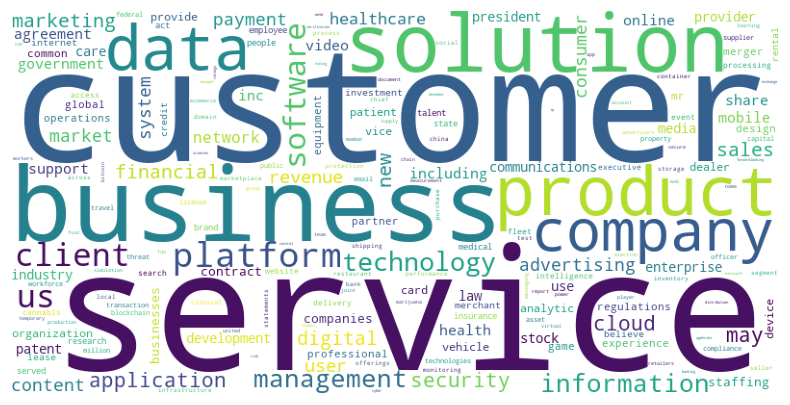

In [23]:
# prepare text
text = ' '.join(wc_keywords['keyword_wc'].tolist())
# lower max_font_size
wcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

plt.figure(figsize = (10,5))
plt.imshow(wcloud)
plt.savefig('keyword_wc.png') # save as PNG file
plt.axis('off')
plt.show()

World Cloud from `tfidf`

   We created a new set of keywords using `tfidf`, convert these keywords into a list and <br>create a new column using the keywords obtained from `tfidf`

In [24]:
# get the keywords based on tfidf
# create a new column using the text from tfidf
keywords_tfidf = get_keywords_tfidf(wc_keywords.clean_text.tolist())
wc_keywords['keyword_clean_tfidf'] =  keywords_tfidf
wc_keywords.head()

,gvkey,name,item_1_text,clean_text,keyword_wc,keyword_clean_tfidf
0,1084,WORLDS INC,"General On March 31, 2011, it was announced th...",general march 31 2011 announced board determin...,worlds inc 3d technology virtual company paten...,worlds 3d worldsplayer avatars worldsshaper bu...
1,1084,MARIMED INC.,Overview MariMed Inc. (the Company ) is a lea...,overview marimed inc company leader emerging c...,company cannabis products 2019 state gencanna ...,cannabis company gencanna hemp cbd cultivation...
32,1410,ABM INDUSTRIES INC /DE/,"General ABM Industries Incorporated, which ope...",general abm industries incorporated operates s...,abm services president vice business 2020 empl...,abm parking president vice janitorial arrangem...
58,1562,AMERICAN SOFTWARE INC,Special Cautionary Notice Regarding Forward-Lo...,special cautionary notice regarding forwardloo...,supply chain services customers product planni...,supply chain planning customers product softwa...
85,1878,"Autodesk, Inc.",Note: A glossary of terms used in this Form 10...,note glossary terms used form 10k appears end ...,software customers products design revenue pro...,autodesk autocad software construction arr cus...


We convert the keywords obtained from `tfidf` to a single string using `''.join()` funtion and we <br>use the world cloud module to generate a word cloud of these keywords.

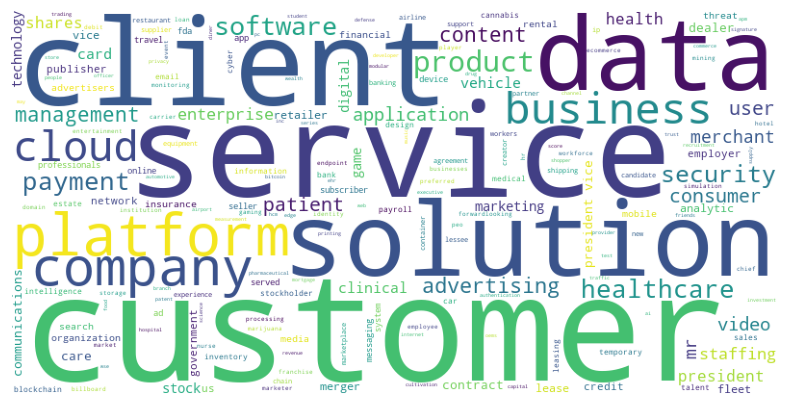

In [25]:
# convert the entire keywords to a single string
text2 = ' '.join(wc_keywords['keyword_clean_tfidf'])
# lower max_font_size
wcloud2 = WordCloud(width = 800, height = 400, background_color = 'white').generate(text2)
plt.figure(figsize = (10,5))
plt.imshow(wcloud2)
plt.savefig('keyword_wc2.png') # save as PNG file
plt.axis('off')

plt.show()

E.	Word embedding: 

In this section, we trained a word2vec using the full 10-K data and analyzed word similarities.
1.	Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.
2.	Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.


First we created a copy of the dataset we need for the training, extracted the `clean_text` column<br>
converted row to a list of words and trained the Word2Vec model using the clean text

In [26]:
# create a copy of the full 10-K dataset
word_sim = df_firms.copy()
words = [row.split() for row in word_sim['clean_text']]

# training word2vec model using the list of words
model = Word2Vec(words, min_count = 1, vector_size = 50, workers = 3, window = 3, sg = 1)

In [27]:
# saving and loading the model
model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")

Bsed on manual inspection of the the wordclouds we generated in `D.3`, we have chose three representative keywords that are relevant to the business sector.<br> We used the trained word2vec model to find the most relevant five words for each of these three keywords.


The code block creates a list of the three representative keywords<br>
The code iterates through the list of representative keywords, finds the five most similar prints the most similar words

In [28]:
# list of the representative words
rep_keywords = ['solution', 'service', 'customer']

# for loop iterates throught the list and returns the most similar words
for rep_word in rep_keywords:
    relevant_words = model.wv.most_similar(rep_word)[:5]
    print(f'{rep_word}: {relevant_words} \n')


solution: [('endtoend', 0.8852078318595886), ('toolkit', 0.8801764845848083), ('solutions', 0.8701006174087524), ('preintegrated', 0.8663806319236755), ('integrated', 0.8628953695297241)] 

service: [('aftersales', 0.8605860471725464), ('aftersale', 0.8482579588890076), ('postsale', 0.8285574316978455), ('•professional', 0.8258025646209717), ('helpdesk', 0.8131685256958008)] 

customer: [('client', 0.9406557083129883), ('endcustomer', 0.9176333546638489), ('customers', 0.8901467323303223), ('enduser', 0.8654171228408813), ('postsale', 0.8559941053390503)] 



Part 3. Comprehensive Analysis of Oracle Corp:<br>

   In this section we created firm level embeddings for each firm and used that embedding to find the top 10 competitors of `Oracle Corp`

In [29]:
# create a copy of the dataset
extracted_keywords = wc_keywords.copy()
extracted_keywords.head()

,gvkey,name,item_1_text,clean_text,keyword_wc,keyword_clean_tfidf
0,1084,WORLDS INC,"General On March 31, 2011, it was announced th...",general march 31 2011 announced board determin...,worlds inc 3d technology virtual company paten...,worlds 3d worldsplayer avatars worldsshaper bu...
1,1084,MARIMED INC.,Overview MariMed Inc. (the Company ) is a lea...,overview marimed inc company leader emerging c...,company cannabis products 2019 state gencanna ...,cannabis company gencanna hemp cbd cultivation...
32,1410,ABM INDUSTRIES INC /DE/,"General ABM Industries Incorporated, which ope...",general abm industries incorporated operates s...,abm services president vice business 2020 empl...,abm parking president vice janitorial arrangem...
58,1562,AMERICAN SOFTWARE INC,Special Cautionary Notice Regarding Forward-Lo...,special cautionary notice regarding forwardloo...,supply chain services customers product planni...,supply chain planning customers product softwa...
85,1878,"Autodesk, Inc.",Note: A glossary of terms used in this Form 10...,note glossary terms used form 10k appears end ...,software customers products design revenue pro...,autodesk autocad software construction arr cus...


Extract `Oracle Corp` from the dataset to get the firm's `gvkey`

In [30]:
# Retrieve Oracle Corp from the dataset to get the firm's gvkey
extracted_keywords[extracted_keywords.name == 'ORACLE CORP']

,gvkey,name,item_1_text,clean_text,keyword_wc,keyword_clean_tfidf
977,12142,ORACLE CORP,Oracle provides products and services that add...,oracle provides products services address ente...,oracle cloud offerings services customers prod...,oracle cloud iaas offerings hardware database ...


Using the tained model in `E.1` we created firm-level embeddings for each firm and <br>used the firm-level embeddings to find the firms competing with `Oracle Corp` (most similar firms). 

In [31]:
# the firm-level embeddings for each firm
d = DocumentSimilarity(model = model, gvkeys = extracted_keywords['gvkey'], conm = extracted_keywords['name'], 
                       keywordslist = extracted_keywords['keyword_clean_tfidf'])

The firm's (`Oracle Corp`) embedding based on word2vec vectors

In [32]:
# get the embedding for oracle corp
d.get_firm_embedding(firm = 12142)


array([-0.02092701,  0.10754005,  0.11731037, -0.0593541 , -0.06248301,
       -0.13127492,  0.20182729,  0.22050238, -0.15518889, -0.2018923 ,
        0.11145639, -0.01955152,  0.01592275,  0.18929444,  0.02252671,
       -0.0719896 ,  0.1111377 ,  0.14374523, -0.14404906, -0.04623825,
        0.07691675,  0.13571024, -0.03169139, -0.18514358,  0.08311574,
        0.12828387,  0.09672098, -0.09274858, -0.09326003,  0.092781  ,
        0.03796559, -0.09137685, -0.11131898,  0.12177429,  0.06328963,
        0.12811203,  0.02547221,  0.07169691,  0.01473103, -0.20245786,
        0.25264195, -0.0400602 ,  0.06288569, -0.02081381,  0.12672903,
        0.08014767, -0.07103966, -0.18096608,  0.09506342, -0.05945359],
      dtype=float32)

`Oracle's` top ten competitors

In [33]:
# get the most similar firms
d.most_similar(firm = 12142, topn = 10)

[(22182, 'NEW RELIC, INC.', 0.9645637),
 (166562, 'VONAGE HOLDINGS CORP', 0.9624986),
 (35447, 'Dynatrace, Inc.', 0.96038735),
 (24135, 'Alarm.com Holdings, Inc.', 0.95531195),
 (122902, 'NETSCOUT SYSTEMS INC', 0.9521613),
 (61870, 'OPEN TEXT CORP', 0.94947946),
 (157855, 'SALESFORCE.COM, INC.', 0.949276),
 (61676, 'CITRIX SYSTEMS INC', 0.94702756),
 (32855, 'Avaya Holdings Corp.', 0.9458014),
 (31236, 'APPIAN CORP', 0.94526565)]

In [34]:
# Use a for loop to extract the firmsgit
for item in d.most_similar(firm = 12142, topn = 10):
    print(item[1])

NEW RELIC, INC.
VONAGE HOLDINGS CORP
Dynatrace, Inc.
Alarm.com Holdings, Inc.
NETSCOUT SYSTEMS INC
OPEN TEXT CORP
SALESFORCE.COM, INC.
CITRIX SYSTEMS INC
Avaya Holdings Corp.
APPIAN CORP
